# Programming Project #2: Image Quilting

## CS445: Computational Photography


In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time

# modify to where you store your project data including utils.py
datadir = "./"

utilfn = datadir + "utils.py"
!cp "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .
import utils

cp: './utils.py' and './utils.py' are the same file
cp: './samples' and './samples' are the same file


In [2]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture (10 pts)

In [100]:
import random
from PIL import Image
import math

def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """

    # so the idea here is to randomly sample from sample, samples of size patch_size, until we have an image that is of size patch_size

    # get the total range for which we will be pulling 
    height, width, channels = sample_img.shape
    min_x = 0
    max_x = width
    min_y = 0 
    max_y = height

    iterations = (out_size * out_size) / (patch_size * patch_size) 
    
    black_image = np.zeros((out_size, out_size, 3), dtype=np.uint8)

    current_x = 0
    current_y = 0
    while (((out_size - current_y) > patch_size+patch_size)):
        # first we want to get the random sample..
        
        # we want to get the starting values for x and  y to start sampling. We get a random integer from 0 to width (and height) minus the patch size. This ensures that we can actually pull a full image, as the
        # maximum random value we could get here is width - patch_size, so we could get to the edge without exceeding the width of the image
        start_x = random.randint(0, width - patch_size)
        start_y = random.randint(0, height - patch_size)
        
        # therefore, the sample that we will use will just be the area of the image from start_y to start_y + patch size (15) and the same with x. This gives us a patch_size by patch_size sample 
        current_sample = sample[start_y:start_y + patch_size, start_x:start_x + patch_size]

        # then, once we have the random sample, we want to place it in the current wanted location.. we can keep track of where we are by using out_size

        # we will want to place samples down on the black image. Basically, we will manipulate the coordinates depending on where we are.
        # This just checks to see if we are at the edge of the image. If we are, we want to go back to the far left side 
        # print(current_x,current_y)
        if current_x + patch_size > out_size:
            current_x = 0
            current_y += patch_size

        
        # now here, we will actually place the sample down in the black image at the current_x and current_y
        black_image[current_y:current_y + patch_size, current_x:current_x + patch_size] = current_sample

        current_x += patch_size

    return black_image
        


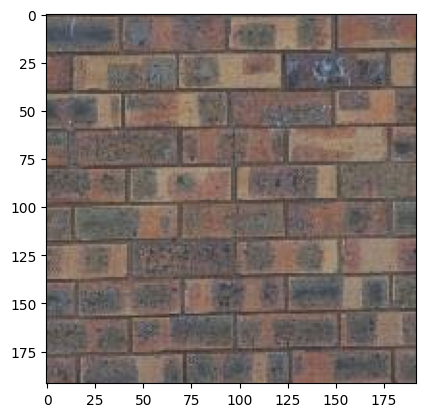

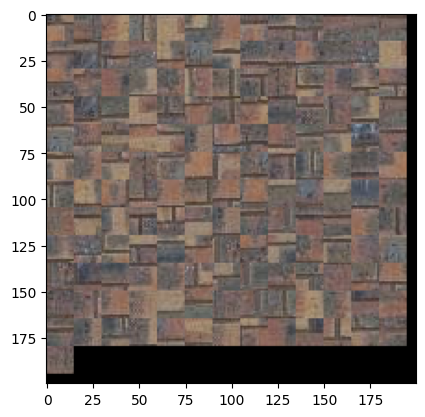

In [103]:
sample_img_fn = 'samples/bricks_small.jpg' # feel free to change
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 200  # change these parameters as needed
patch_size = 15
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.imshow(res)

### Part II: Overlapping Patches (30 pts)

In [ ]:
def quilt_simple(sample, out_size, patch_size, overlap, tol):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """


In [ ]:
sample_img_fn = 'samples/bricks_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 25
overlap = 11
tol = 5
res = quilt_simple(sample_img, out_size, patch_size, overlap, tol) #feel free to change parameters to get best results
if res is not None:
    plt.figure(figsize=(10,10))
    plt.imshow(res)

### Part III: Seam Finding (20 pts)


In [ ]:
# optional or use cut(err_patch) directly
def customized_cut(bndcost):
    pass

In [ ]:
def quilt_cut(sample, out_size, patch_size, overlap, tol):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """


In [ ]:
sample_img_fn = 'samples/bricks_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 25
overlap = 11
tol = 5
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.figure(figsize=(15,15))
    plt.imshow(res)

### Part IV: Texture Transfer (30 pts)

In [ ]:
def texture_transfer(sample, patch_size, overlap, tol, guidance_im, alpha):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to modify function parameters
    :param sample: numpy.ndarray
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :param guidance_im: target overall appearance for the output
    :param alpha: float 0-1 for strength of target
    :return: numpy.ndarray
    """


In [ ]:
# load/process appropriate input texture and guidance images

patch_size = 25
overlap = 11
tol = 3
alpha = 0.5
res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)

plt.figure(figsize=(15,15))
plt.imshow(res)
plt.show()

### Bells & Whistles

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).